# Folding Influence with Battery
I will test the influence the added tensors made and the battery, also I will test the lift generated with folding and folding and leg movement.

In [121]:
import matplotlib.pyplot as plt
from utils import *
import numpy as np
import plotly.express as px
import pandas as pd
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [122]:
!python -m serial.tools.list_ports
daq_port = '/dev/ttyUSB1'
command_port = "/dev/ttyACM0"

/dev/ttyUSB1        
1 ports found


## Calibration
First we calibrate

measurements = read_measurements_df_6axis(port=daq_port, duration=5)
measurements['Time'] = 0
calib = measurements.mean()
calib.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/folding_influence/data/calib_bat.csv')

In [123]:
# Different calibrations done for the initial and corrected experiment.
calib = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/folding_influence/data/calib_bat.csv', index_col=0).iloc[:,0]

In [124]:
calib

Time    0.000000
Fx      2.622616
Fy      2.650000
Fz     -9.842043
Mx     -0.104123
My      0.012697
Mz      0.115501
Name: 0, dtype: float64

## Measurements

In [125]:
measurements = read_measurements_df_6axis(port=daq_port, duration=20) - calib
measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/folding_influence/data/ascending.csv')

In [115]:
folding_low = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/folding_influence/data/folding_low.csv')
folding_med = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/folding_influence/data/folding_med.csv')
folding_high = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/folding_influence/data/folding_high.csv')
extended_low = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/folding_influence/data/extended_low.csv')
extended_med = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/folding_influence/data/extended_med.csv')
extended_high = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/folding_influence/data/extended_high.csv')
ascending = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/folding_influence/data/ascending.csv')

## Individual Analysis

In [116]:
def peak_slice_interpolate(measurements, args = {'peak_height':0, 'peak_distance':10}):
    """
    Interpolates sensor data between the first and last detected peaks and c
    :param measurements:  (pandas.DataFrame) A DataFrame containing sensor data.
    :return: Interpolated data after slicing from first to last peak
    """
    df = measurements.copy()
    # Find peaks (adjust parameters as discussed previously)
    peaks, _ = find_peaks(df['Fz'], height=args['peak_height'], distance=args['peak_distance'])
    df_sliced = df.iloc[peaks[0]:peaks[-1] + 1].reset_index(drop=True)
    # Now create the new time series with 1000 points
    new_time = np.linspace(df_sliced['Time'].min(), df_sliced['Time'].max(), 1000)
    # Initialize a new DataFrame to store the interpolated values
    interpolated_df = pd.DataFrame(index=new_time)

    # Interpolate each sensor column
    for column in df_sliced.columns:
        if column != 'Time':
            # Create the interpolation function
            interp_func = interp1d(df_sliced['Time'], df_sliced[column], kind='linear', fill_value='extrapolate')
            # Apply the interpolation function to the new time series
            interpolated_df[column] = interp_func(new_time)

    # Reset the index to make 'Time' a column again
    interpolated_df.reset_index(inplace=True)
    interpolated_df.rename(columns={'index': 'Time'}, inplace=True)
    return interpolated_df, peaks

def fitness_avg_force(measurements, plot=False, args = {'peak_height':0, 'peak_distance':10}):
    """
    Interpolates sensor data between the first and last detected peaks and calculates the mean
    of the interpolated 'Fy' and 'Fz' columns to compute a score as the Euclidean norm.

    :param measurements: (pandas.DataFrame) A DataFrame containing sensor data with at least 'Time',
                                       'Fy', and 'Fz' columns.

    :return: score: (float) The Euclidean norm of the mean values of 'Fy' and 'Fz' from the
                     interpolated data.
    """
    df = measurements.copy()
    interpolated_df, peaks = peak_slice_interpolate(df, args)

    # interpolated_df now contains 1000 interpolated data points based on the 'Time' column.

    Fy, Fz = interpolated_df.mean()[['Fy', 'Fz']]
    score = np.sqrt(Fy ** 2 + (Fz) ** 2)

    if plot:
        # Create the base line plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        # Plot 'Fz' column
        ax1.plot(df['Time'], df['Fz'], label='Fz')
        ax1.plot(df['Time'], df['Fy'], label='Fy', zorder=1)
        # Plot the peaks
        ax1.scatter(df['Time'][peaks], df['Fz'][peaks], color='red', s=10, label=f'Peaks {round(1/df.iloc[peaks].Time.diff().mean(),2)}Hz', zorder=5)
        # Adding title and labels
        ax1.legend()
        ax1.set_title(f'Peaks found')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Force')
        # Setting up a simple plot with equal scaling on the axes
        # Setting the aspect of the plot to be equal.
        ax2.set_aspect('equal', adjustable='box')

        # Drawing a simple line for demonstration
        ax2.plot(interpolated_df.Fy, interpolated_df.Fz, zorder=1)
        ax2.scatter(Fy, Fz, c='r', marker='*')
        ax2.scatter(0, 0, c='g', marker='+')
        ax2.arrow(0, 0, Fy, Fz, head_width=0.3, head_length=0.3)

        # Setting labels for the axes
        ax2.set_xlabel('Fy')
        ax2.set_ylabel('Fz')
        ax2.set_title(f'Score: {round(score, 2)}\n Fy: {round(Fy,3)}\n Fz: {round(Fz,3)}')

        # Display the plot
        plt.show()

    return score

<Axes: xlabel='Time'>

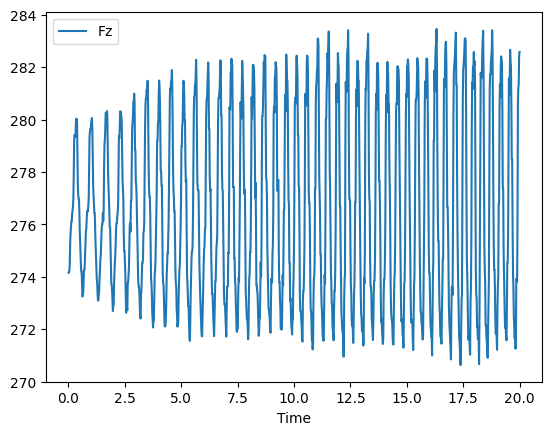

In [117]:
ascending.plot(x='Time',y='Fz')

In [112]:
fitness_avg_force(ascending, plot=True)

IndexError: index 0 is out of bounds for axis 0 with size 0

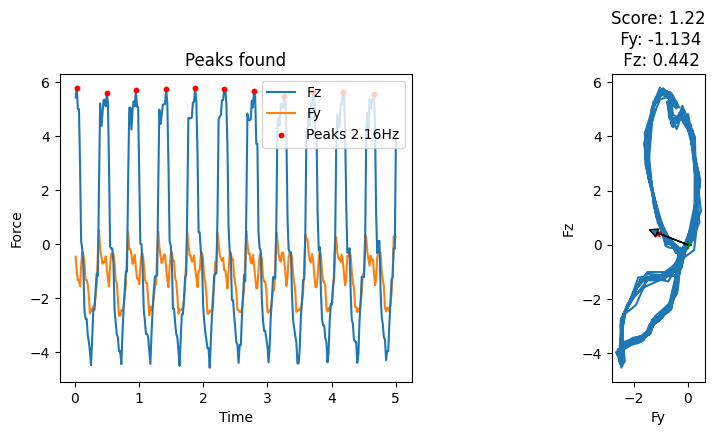

1.217413290716457

In [92]:
fitness_avg_force(extended_med, plot=True)

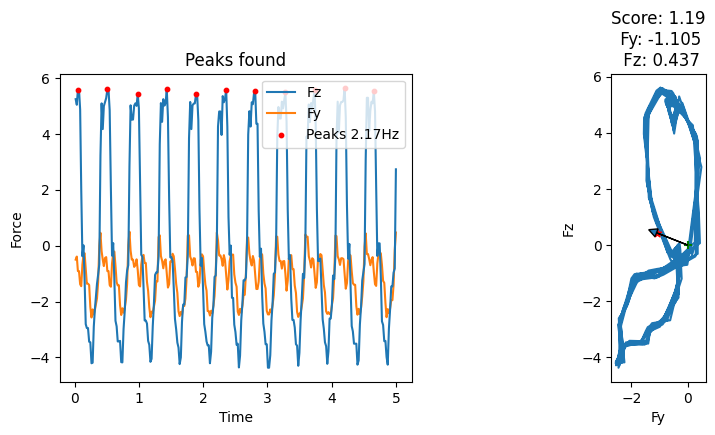

1.188536679975399

In [93]:
fitness_avg_force(extended_high, plot=True)

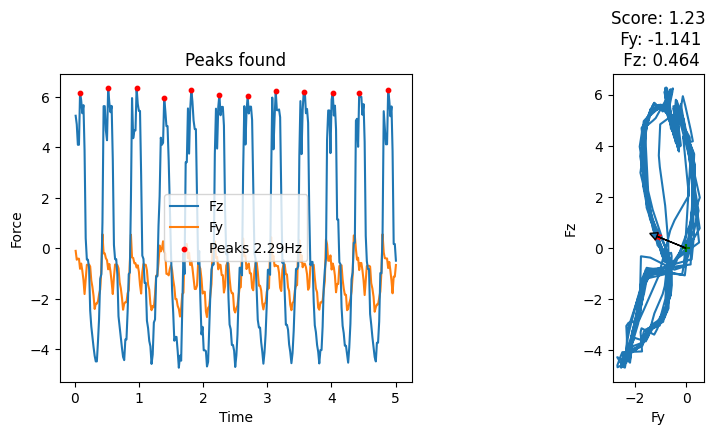

1.2320369233374655

In [94]:
fitness_avg_force(folding_low, plot=True)

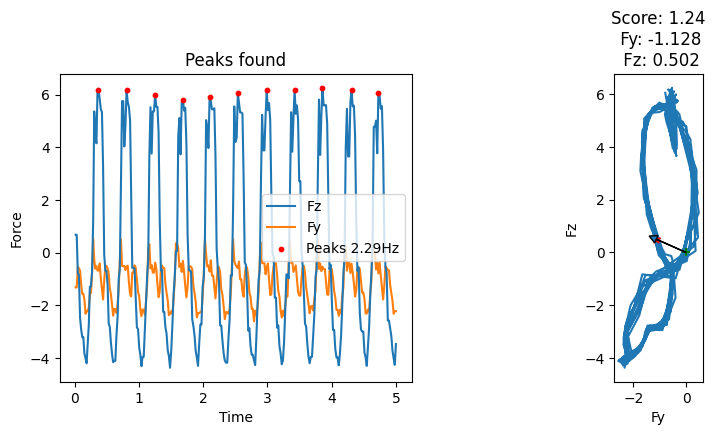

1.2352885378569396

In [95]:
fitness_avg_force(folding_med, plot=True)

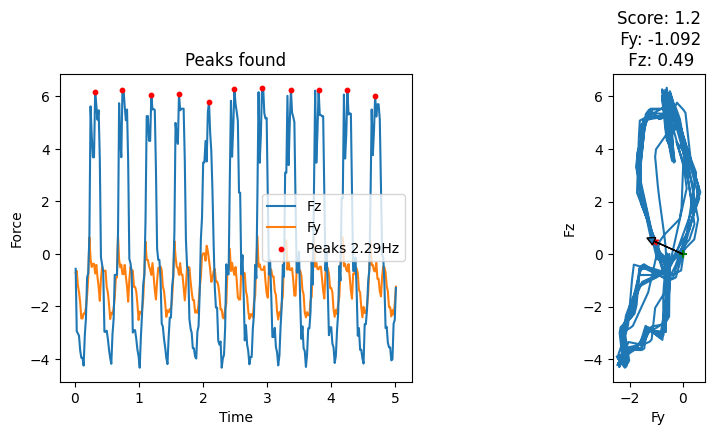

1.196824629073245

In [96]:
fitness_avg_force(folding_high, plot=True)

## Comparison

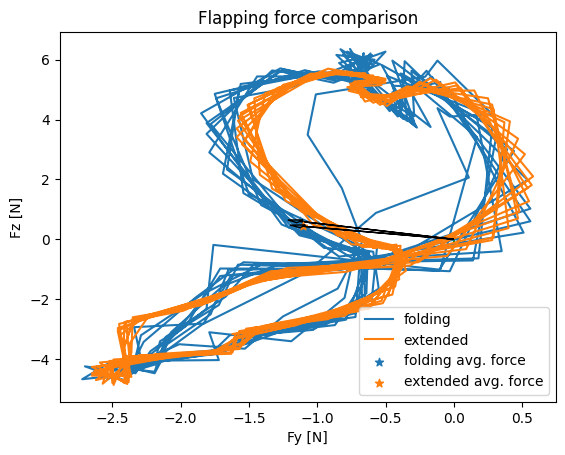

In [31]:
folding = folding_low.copy()
extended = extended_low.copy()
plt.scatter(0, 0, c='g', marker='+')

plt.plot(folding.Fy,folding.Fz, label=f'folding',zorder=1)
plt.plot(extended.Fy,extended.Fz, label=f'extended',zorder=1)

Fz, Fy = folding.mean()[['Fz', 'Fy']]
plt.scatter(Fy, Fz, marker='*', label='folding avg. force')
plt.arrow(0, 0, Fy, Fz, head_width=0.1, head_length=0.1)
Fz, Fy = extended.mean()[['Fz', 'Fy']]
plt.scatter(Fy, Fz, marker='*', label='extended avg. force')
plt.arrow(0, 0, Fy, Fz, head_width=0.1, head_length=0.1)
plt.ylabel('Fz [N]')
plt.xlabel('Fy [N]')
plt.legend()
plt.title('Flapping force comparison')
plt.show()

In [32]:
folding_mean = folding.mean()[['Fy', 'Fz']]
folding_mean['absolute'] = np.sqrt(folding_mean.Fy**2 + folding_mean.Fz**2)

extended_mean = extended.mean()[['Fy', 'Fz']]
extended_mean['absolute'] = np.sqrt(extended_mean.Fy**2 + extended_mean.Fz**2)


df_means = pd.DataFrame({
    'extended mean': extended_mean,
    'folding mean': folding_mean
})
df_means

,extended mean,folding mean
Fy,-1.105461,-1.126364
Fz,0.434596,0.598826
absolute,1.187821,1.275652
